**NOTE** `phimats_rve` environment should be used as kernel

In [1]:
import numpy as np
from datetime import datetime
import h5py
import meshio
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, cm
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

from importlib import reload

import FEM_tools
from FEM_tools import *

In [2]:
def CPlot2D(Cx, dpi=100, cmap='RdBu_r'):
                
    fig, ax = plt.subplots(1, 1, figsize=(1*56.25/25.4, 1.5*56.25/25.4), dpi=dpi, tight_layout=True)
    
    c = ax.contourf(Cx, 256, cmap=cmap, vmin=Cx.min(), vmax=Cx.max())
    cbar = fig.colorbar(c, ax=ax, ticks=np.linspace(Cx.min(), Cx.max(), 4), orientation="horizontal", pad=0.05)

    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

#### Read $g(\phi)$

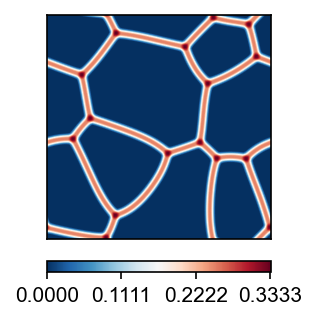

In [3]:
fileName = "GB_2D.hdf5"
fh5 = h5py.File(fileName, "r")

nStep = 60000

with h5py.File("GB_2D.hdf5", "r") as fh5:
    gPhi = fh5["Arrays/gPhi/gPhi_"+str(60000)][()]

CPlot2D(gPhi, dpi=150)

### Resample

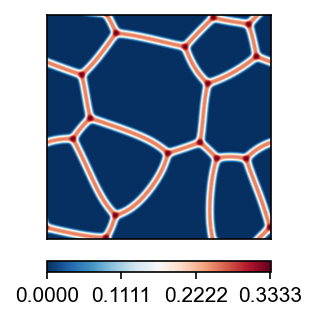

In [14]:
Mx = 500 # New array size, can be modified
gPhi_resamp = Resample2D(gPhi, Mx)
CPlot2D(gPhi_resamp, dpi=150)

### Develop a structured finite element mesh using Gmsh for interpolation

In [15]:
Lx = 100e-6 # RVE edge size
CreateStructuredMesh(Lx, Mx)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000963349s, CPU 0.001598s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.0370115s, CPU 0.036027s)
Info    : 250000 nodes 500002 elements
Info    : Writing 'RVE_structured.inp'...
Info    : Done writing 'RVE_structured.inp'
Mesh saved to 'RVE_structured.inp'


#### Map order parameter values to structured finite element grid

In [16]:
# Coordinates of the structured grid

x = np.linspace(0, Lx, gPhi.shape[1])  
y = np.linspace(0, Lx, gPhi.shape[0])
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

values_gPhi = gPhi.ravel()

In [17]:
# Read the generated mesh
modelName = "RVE_structured"
mesh = meshio.read(modelName+".inp")
print(mesh)

nodCoord = mesh.points[:,0:2]            # node coordinates

<meshio mesh object>
  Number of points: 250000
  Number of cells:
    triangle: 498002
  Point sets: RVE
  Cell sets: RVE, Surface1


In [18]:
# Map gPhi to FEM nodes
gPhi_mapped = griddata(points, values_gPhi, nodCoord, method='cubic')

In [19]:
# Make sure gPhi_mapped has no NaN
gPhi_mapped[np.argwhere(np.isnan(gPhi_mapped))]=0
print(np.argwhere(np.isnan(gPhi_mapped)))

# Make sure all gPhi_mapped values are positive
gPhi_mapped[gPhi_mapped<1e-5] = 0

[]


In [20]:
# Inspect mapped data in Paraview
mesh.point_data["gPhi"] = gPhi_mapped
meshio.write("fem_mesh_with_gPhi_mapped.vtk", mesh)

Info: VTK format cannot write point_sets. Converting them to point_data...

Info: VTK format cannot write cell_sets. Converting them to cell_data...

In [21]:
# Save the mapped data to hdf5 to be used in PHIMATS preprocessing. 
with h5py.File("GB_2D_PHIMATS.hdf5", "w") as fh5:
    fh5.create_dataset("gPhi", data=gPhi_mapped, dtype=np.float64)

**After the conversion to FEM is done, move the generated .inp and _PHIMATS.hdf5 to simulation folder in PHIMATS**